In [ ]:
import pandas as pd

df = pd.read_csv("../data/raw/sales_train.csv")

In [ ]:
# import pandas as pd

# # Load dữ liệu
# df2 = pd.read_csv("../data/raw/online_retail.csv", encoding="latin1")

# # Chuyển InvoiceDate sang datetime
# df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'], dayfirst=True)

# # Thêm date_block_num theo tháng
# df2['date_block_num'] = (df2['InvoiceDate'].dt.year - 2010) * 12 + (df2['InvoiceDate'].dt.month - 1)

# # Nếu chỉ có 1 shop: tạo shop_id = 0
# df2['shop_id'] = 0

# # Map StockCode thành item_id
# df2['item_id'] = df2['StockCode'].astype('category').cat.codes

# # Group theo ngày + item + shop
# df2_new = df2.groupby(['InvoiceDate','date_block_num','shop_id','item_id']).agg({
#     'UnitPrice':'mean',  # trung bình nếu nhiều đơn trong ngày
#     'Quantity':'sum'
# }).reset_index()

# # Đổi tên cột và chuyển date về format DD.MM.YYYY
# df2_new.rename(columns={
#     'InvoiceDate':'date',
#     'UnitPrice':'item_price',
#     'Quantity':'item_cnt_day'
# }, inplace=True)

# df2_new['date'] = df2_new['date'].dt.strftime('%d.%m.%Y')

# df = df2_new.copy()

# print(df2_new.head())


/var/folders/x8/3s0s9pbj7bgb2h7w5bbd8v7h0000gn/T/ipykernel_85079/472977954.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'], dayfirst=True)


         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  12.01.2010               0        0      800        4.25             6
1  12.01.2010               0        0     1662        7.65             2
2  12.01.2010               0        0     2794        3.39             6
3  12.01.2010               0        0     2984        3.39             6
4  12.01.2010               0        0     2985        3.39             6


In [250]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [251]:
total_cnt_day = df['item_cnt_day'].sum()
print(total_cnt_day)

5176450


In [252]:
block_cnt = df['item_cnt_day'].groupby(df['date_block_num']).sum()

In [253]:
total_cnt = block_cnt.sum()

In [254]:
sold = df[df['item_cnt_day'] >= 0]
return_goods = df[df['item_cnt_day'] < 0]

In [255]:
print(sold['item_cnt_day'].sum())
print(return_goods['item_cnt_day'].sum())

5656274
-479824


In [256]:
unique_date_per_block_num = df['date'].groupby(df['date_block_num']).nunique()
print(unique_date_per_block_num)

date_block_num
0      1
1      1
2      1
4      1
5      1
6      1
7      1
8      1
9      1
11    11
12    26
13    22
14    26
15    22
16    24
17    27
18    27
19    25
20    26
21    26
22    26
23     8
Name: date, dtype: int64


ta thấy block nào cũng đủ date trong tháng -> có thể tính tổng days = nunique cột date

In [257]:
total_days_of_selling = unique_date_per_block_num.sum()

print(total_days_of_selling)

305


In [258]:
non_zero_demand_days = df['date'].groupby(sold['item_id']).nunique()

zero_demand_days = total_days_of_selling - non_zero_demand_days

zero_ratio = zero_demand_days / total_days_of_selling

print(non_zero_demand_days)
print(zero_demand_days)
print(zero_ratio)

item_id
0.0       47
1.0       22
2.0       24
3.0        3
5.0        5
          ..
4065.0    10
4066.0     7
4067.0     3
4068.0     4
4069.0     1
Name: date, Length: 3940, dtype: int64
item_id
0.0       258
1.0       283
2.0       281
3.0       302
5.0       300
         ... 
4065.0    295
4066.0    298
4067.0    302
4068.0    301
4069.0    304
Name: date, Length: 3940, dtype: int64
item_id
0.0       0.845902
1.0       0.927869
2.0       0.921311
3.0       0.990164
5.0       0.983607
            ...   
4065.0    0.967213
4066.0    0.977049
4067.0    0.990164
4068.0    0.986885
4069.0    0.996721
Name: date, Length: 3940, dtype: float64


đếm tổng string khác nhau của 1 loại item => số ngày mà sản phẩm đó được bán

In [259]:
print(non_zero_demand_days.describe())

count    3940.000000
mean       70.262944
std        68.518056
min         1.000000
25%        15.000000
50%        49.000000
75%       106.000000
max       305.000000
Name: date, dtype: float64


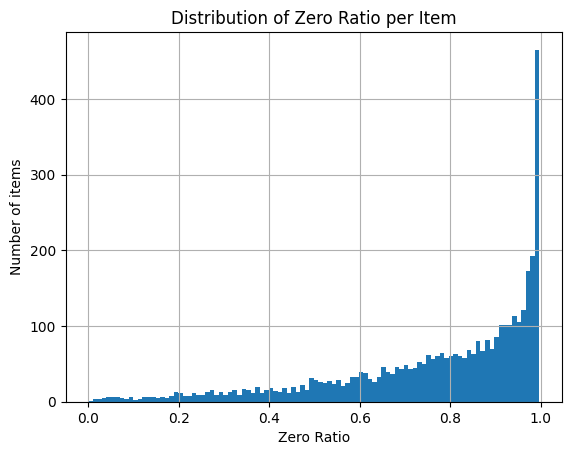

count    3940.000000
mean        0.769630
std         0.224649
min         0.000000
25%         0.652459
50%         0.839344
75%         0.950820
max         0.996721
Name: date, dtype: float64


In [260]:
zero_ratio.hist(bins=100)
plt.xlabel('Zero Ratio')
plt.ylabel('Number of items')
plt.title('Distribution of Zero Ratio per Item')
plt.show()
print(zero_ratio.describe())

In [261]:
day_sell_of_item = df['date'].groupby(sold['item_id']).unique()

In [262]:
items_df = pd.concat([zero_ratio, day_sell_of_item], axis=1)
items_df.columns = ['zero_ratio', 'days_sold']
print(items_df)

         zero_ratio                                          days_sold
item_id                                                               
0.0        0.845902  [12.01.2010, 12.02.2010, 12.03.2010, 12.05.201...
1.0        0.927869  [08.01.2011, 08.02.2011, 11.02.2011, 27.02.201...
2.0        0.921311  [12.03.2010, 12.08.2010, 12.10.2010, 08.02.201...
3.0        0.990164               [12.03.2010, 31.03.2011, 03.04.2011]
5.0        0.983607  [12.06.2010, 17.03.2011, 27.03.2011, 11.06.201...
...             ...                                                ...
4065.0     0.967213  [13.01.2011, 15.02.2011, 08.04.2011, 18.04.201...
4066.0     0.977049  [09.02.2011, 17.02.2011, 18.02.2011, 01.05.201...
4067.0     0.990164               [20.12.2010, 04.04.2011, 27.07.2011]
4068.0     0.986885   [23.12.2010, 05.06.2011, 24.06.2011, 30.06.2011]
4069.0     0.996721                                       [21.12.2010]

[3940 rows x 2 columns]


In [263]:
from src.utils.date_caculator import compute_interarrival
items_df['interarrival'] = items_df['days_sold'].map(compute_interarrival)


In [264]:
items_df['var_demand_days'] = sold['item_cnt_day'].groupby(sold['item_id']).var()
items_df['mean_demand_days'] = sold['item_cnt_day'].groupby(sold['item_id']).mean()
items_df['cv2'] = items_df['var_demand_days'] / (items_df['mean_demand_days'] ** 2)


In [265]:
items_df['ADI'] = items_df['interarrival'].apply(np.mean)

print(items_df)

         zero_ratio                                          days_sold  \
item_id                                                                  
0.0        0.845902  [12.01.2010, 12.02.2010, 12.03.2010, 12.05.201...   
1.0        0.927869  [08.01.2011, 08.02.2011, 11.02.2011, 27.02.201...   
2.0        0.921311  [12.03.2010, 12.08.2010, 12.10.2010, 08.02.201...   
3.0        0.990164               [12.03.2010, 31.03.2011, 03.04.2011]   
5.0        0.983607  [12.06.2010, 17.03.2011, 27.03.2011, 11.06.201...   
...             ...                                                ...   
4065.0     0.967213  [13.01.2011, 15.02.2011, 08.04.2011, 18.04.201...   
4066.0     0.977049  [09.02.2011, 17.02.2011, 18.02.2011, 01.05.201...   
4067.0     0.990164               [20.12.2010, 04.04.2011, 27.07.2011]   
4068.0     0.986885   [23.12.2010, 05.06.2011, 24.06.2011, 30.06.2011]   
4069.0     0.996721                                       [21.12.2010]   

                                     

/Users/cps/Library/Caches/pypoetry/virtualenvs/data-science-ecommerce-cOQ0u3NZ-py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cps/Library/Caches/pypoetry/virtualenvs/data-science-ecommerce-cOQ0u3NZ-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [266]:
q3_adi = items_df["ADI"].quantile(0)
q3_zero_ratio = items_df["zero_ratio"].quantile(0)
q3_cv2  = items_df['cv2'].quantile(0)


filter_items = items_df[items_df["ADI"] > q3_adi]
filter_items = filter_items[filter_items["zero_ratio"] > q3_zero_ratio]
filter_items = filter_items[filter_items["zero_ratio"] > q3_cv2]


print(filter_items.describe())

        zero_ratio  var_demand_days  mean_demand_days          cv2  \
count  3779.000000     3.779000e+03       3779.000000  3779.000000   
mean      0.760219     8.577540e+03          9.268161     3.482657   
std       0.224029     3.715234e+05         25.769284     7.384485   
min       0.013115     0.000000e+00          1.000000     0.000000   
25%       0.642623     8.422330e+00          2.813169     0.777622   
50%       0.826230     6.409766e+01          5.692308     1.717813   
75%       0.940984     3.522831e+02         10.459295     3.793232   
max       0.993443     2.229064e+07       1300.000000   223.336547   

               ADI  
count  3779.000000  
mean     24.114588  
std      40.367505  
min       1.381679  
25%       5.119430  
50%       9.964912  
75%      24.920113  
max     565.000000  


In [267]:
items_df.to_csv("../data/processed/items_zero_ratio_days_sold.csv", index=True)

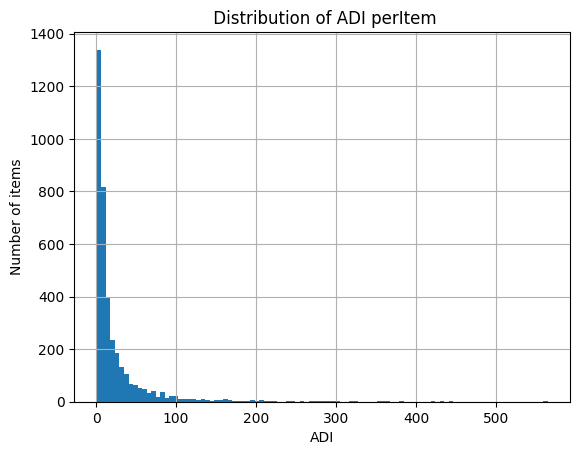

In [273]:
items_df['ADI'].hist(bins=100)
plt.xlabel('ADI')
plt.ylabel('Number of items')
plt.title(' Distribution of ADI perItem')
plt.show()


In [269]:

df_visual = filter_items[["ADI", "cv2", "zero_ratio"]].dropna().copy()

def label_demand(row):
    if row['ADI'] >= 1.32 or row['zero_ratio'] >= 0.6:
        return 0
    elif row['cv2'] < 0.49 and row['ADI'] < 1.32:
        return 1
    else:
        return 2

df_visual['demand_type'] = df_visual.apply(label_demand, axis=1)

print(df_visual['demand_type'].value_counts())

demand_type
0    3779
Name: count, dtype: int64


                       ADI       cv2  zero_ratio
kmeans_cluster                                  
0                 4.043212  7.412915    0.445356
1               144.223030  0.479034    0.987517
2                20.093763  2.267517    0.858869


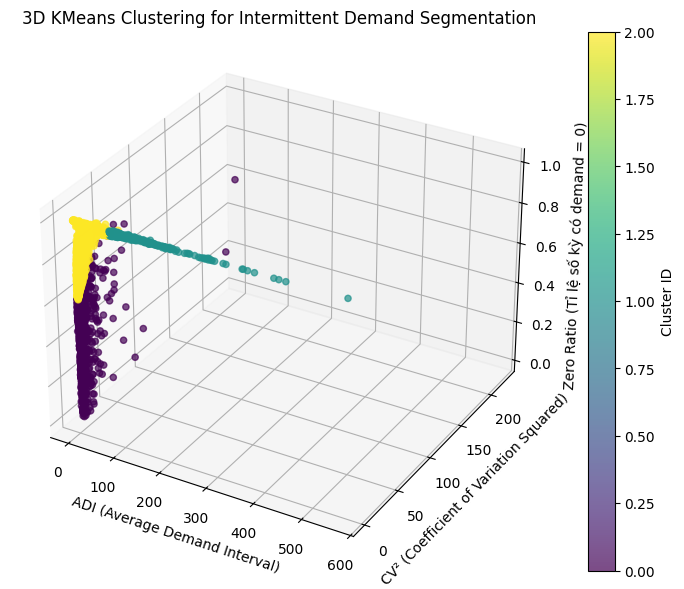

In [271]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Giả sử df_visual đã có cột ADI, cv2, zero_ratio
X = df_visual[['ADI','cv2','zero_ratio']].fillna(0)

# Chuẩn hóa dữ liệu để KMeans không bị ảnh hưởng bởi scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Khởi tạo KMeans với 3 cluster
kmeans = KMeans(n_clusters=3, random_state=42)
df_visual['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Kiểm tra trung bình từng cluster
print(df_visual.groupby('kmeans_cluster')[['ADI','cv2','zero_ratio']].mean())

# Vẽ 3D scatter plot theo cluster KMeans
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    df_visual["ADI"],
    df_visual["cv2"],
    df_visual["zero_ratio"],
    c=df_visual["kmeans_cluster"],
    cmap="viridis",
    alpha=0.7
)

ax.set_xlabel("ADI (Average Demand Interval)")
ax.set_ylabel("CV² (Coefficient of Variation Squared)")
ax.set_zlabel("Zero Ratio (Tỉ lệ số kỳ có demand = 0)")
ax.set_title("3D KMeans Clustering for Intermittent Demand Segmentation")

fig.colorbar(sc, ax=ax, label="Cluster ID")
plt.show()

                   ADI       cv2  zero_ratio
gmm_cluster                                 
0             4.597584  7.061635    0.492152
1            72.356143  0.725110    0.975052
2            13.277797  2.416642    0.835906


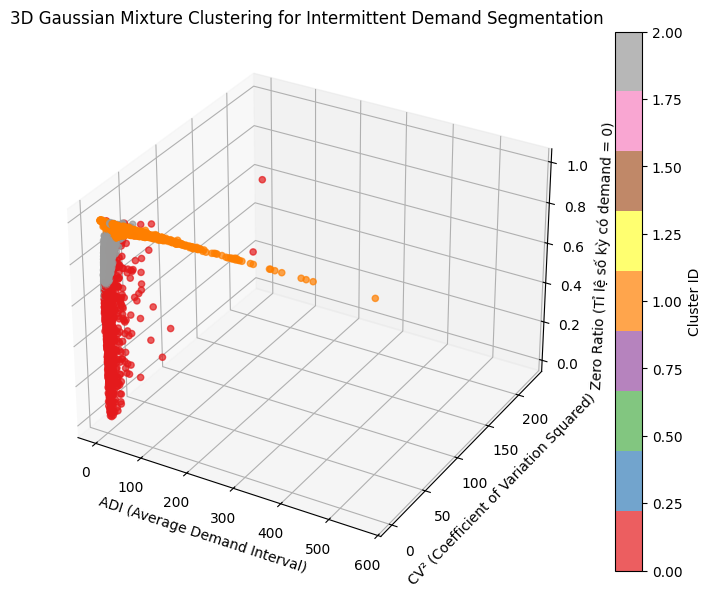

In [274]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Giả sử df_visual đã có cột ADI, cv2, zero_ratio
X = df_visual[['ADI','cv2','zero_ratio']].fillna(0)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Khởi tạo GMM với 3 component
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
df_visual['gmm_cluster'] = gmm.fit_predict(X_scaled)

# Kiểm tra trung bình từng cluster
print(df_visual.groupby('gmm_cluster')[['ADI','cv2','zero_ratio']].mean())

# Vẽ 3D scatter plot theo cluster GMM
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    df_visual["ADI"],
    df_visual["cv2"],
    df_visual["zero_ratio"],
    c=df_visual["gmm_cluster"],
    cmap="Set1",
    alpha=0.7
)

ax.set_xlabel("ADI (Average Demand Interval)")
ax.set_ylabel("CV² (Coefficient of Variation Squared)")
ax.set_zlabel("Zero Ratio (Tỉ lệ số kỳ có demand = 0)")
ax.set_title("3D Gaussian Mixture Clustering for Intermittent Demand Segmentation")

fig.colorbar(sc, ax=ax, label="Cluster ID")
plt.show()


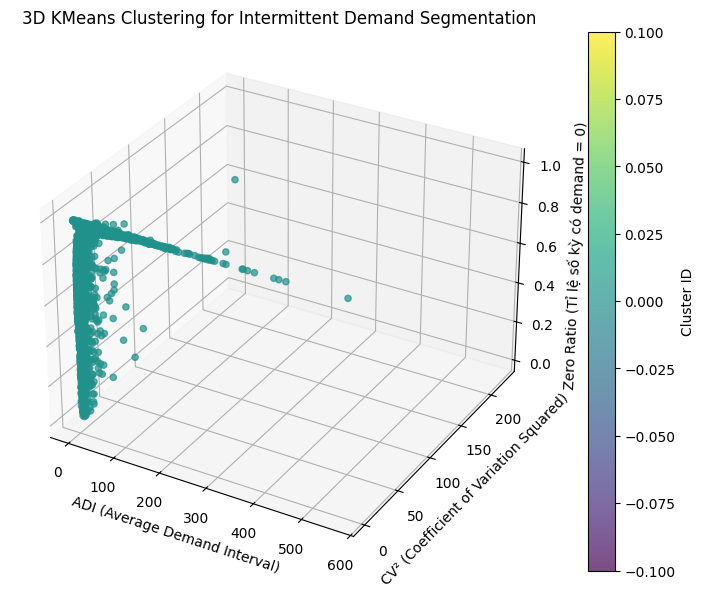

In [270]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    df_visual["ADI"],
    df_visual["cv2"],
    df_visual["zero_ratio"],
    c=df_visual["demand_type"],
    cmap="viridis",
    alpha=0.7
)

ax.set_xlabel("ADI (Average Demand Interval)")
ax.set_ylabel("CV² (Coefficient of Variation Squared)")
ax.set_zlabel("Zero Ratio (Tỉ lệ số kỳ có demand = 0)")
ax.set_title("3D KMeans Clustering for Intermittent Demand Segmentation")

fig.colorbar(sc, ax=ax, label="Cluster ID")
plt.show()